In [3]:
# 기본 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

---

# 1. MNIST

In [4]:
# Dataset 불러오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

> 불러온 데이터셋은 딕셔너리 구조를 가지고 있으며, keys() 메소드를 통해 확인해보면 다양한 정보들이 포함되어 있다.
> - `data`: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data
> - `target`: 레이블 배열
> - `DESCR`: 데이터셋의 설명

In [5]:
X, y = mnist['data'], mnist['target']

# 데이터의 형태 확인
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


> - 데이터의 shape을 통해 총 70,000개의 이미지가 있으며 각 이미지에는 784개의 특성이 있음을 알 수 있다.
    - 이미지가 28x28 픽셀이기 때문이다.
    - 각 특성은 0(흰색)\~255(검은색)까지의 픽셀 강도를 나타낸다.

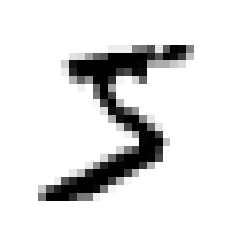

In [6]:
# 샘플 이미지 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]  # 1개의 샘플 이미지 선택
some_digit_image = some_digit.reshape(28, 28)  # 배열 크기 전환(28x28)

plt.imshow(some_digit_image, cmap='binary')    # binary: 흰색-검은색
plt.axis('off')  # 축 제거
plt.show()

In [7]:
y[0]  # >> 이미지와 실제 레이블이 동일함을 알 수 있다.

'5'

> 실제 레이블을 확인해보았을 때 이미지와 동일함을 알 수 있다.
> - 이때, 레이블은 문자열인 것으로 확인되므로 머신러닝에 활용하기 위해 정수형으로 변환해주어야 한다.

In [8]:
y = y.astype(np.uint8)  # uint8: 2^8개(0~255)의 양수만 표현이 가능(unsigned integer)

> Dataset을 자세히 살펴보기 전 테스트 세트를 떼어놓아야 한다.
> - MNIST 데이터셋은 이미 훈련 세트(앞쪽 60,000개 이미지)와 테스트 세트(뒤쪽 10,000개 이미지)로 나뉘어져 있다.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]  # 테스트 세트 분할

# 2. 이진 분류기 훈련

In [10]:
y_train_5 = (y_train == 5)  # 5는 True, 나머지 숫자는 모두 False(이진 분류)
y_test_5 = (y_test == 5)

In [11]:
# SGDClassifier 모델 학습
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])  # 숫자 5(some_digit)에 대한 모델의 예측

array([ True])

> 숫자 5를 구분하는 이진 분류 모델이 some_digit에 대해 True라고 예측하였다.`정확하게 맞췄다!`

# 3. 성능 측정

## 3.1. 교차 검증을 사용한 정확도 측정

> 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 경우 기능을 직접 구현해도 된다!
> - 아래의 코드는 사이킷런의 `cross_val_score()` 함수와 유사한 작업을 수행한다.

In [13]:
# 교차 검증 직접 구현하기
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [14]:
# sklearn을 이용한 교차 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

> 교차 검증을 통한 정확도는 모두 85% 이상 측정됨을 알 수 있다!

> 모델의 정확도에 대해 자세히 살펴보며 비교하기 위해 모든 이미지를 "5가 아님"으로 분류하는 더미 분류기를 만들어 보자.
> - sklearn.base의 BaseEstimator를 사용하면 직접 변환기를 만들 수 있다.

In [15]:
# 모든 이미지를 "5가 아님" 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
# cross_val_score() 함수를 사용하여 더미 분류기의 평가 점수(정확도)를 반환
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

> 모든 이미지를 "5가 아님"으로 분류하는 모델의 교차 검증을 실시한 결과 정확도가 90% 이상으로 나왔다.
> - 이는 이미지의 10% 정도만 숫자 5이기 때문이다.
> - 불균형 데이터셋을 다룰 때 정확도가 분류기의 성능 측정 지표로써 선호되지 않는 이유이다.

## 3.2. 오차 행렬

In [17]:
# cross_val_predict() 함수를 사용하여 교차 검증 예측 결과 반환
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
# 오차 행렬(confusion matrix) 생성
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
# 완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

> 위의 예시에서 오차 행렬의 의미는 아래의 표와 같다.

<table>
  <tr>
    <th rowspan="2", colspan="2">Confusion matrix</th>
    <th colspan="2">예측결과</th>
  </tr>
  <tr>
    <th>Negative(5가 아님)</th>
    <th>Positive(5가 맞음)</th>
  </tr>
  <tr>
    <th rowspan="2">실제 정답</th>
    <th>Negative(5가 아님)</th>
    <th>TN(True Negative)</th>
    <th>FP(False Positive)</th>
  </tr>
  <tr>
    <th>Positive(5가 맞음)</th>
    <th>FN(False Negative)</th>
    <th>TP(True Positive)</th>
  </tr>
</table>

## 3.3. 정밀도와 재현율

> 사이킷런은 정밀도(Precision)와 재현율(Recall)을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

In [20]:
from sklearn.metrics import precision_score, recall_score

print("Precision Score:", precision_score(y_train_5, y_train_pred))    # 정밀도
print("Recall Score:", recall_score(y_train_5, y_train_pred))          # 재현율

Precision Score: 0.8370879772350012
Recall Score: 0.6511713705958311


In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)    # F1 Score

0.7325171197343846

## 3.4. 정밀도/재현율 트레이드오프

> 정밀도와 재현율은 trade off 관계에 있기 때문에, 둘의 값을 모두 올릴 수 없다.

> 사이킷런에서 임계값을 직접 지정할 수는 없지만, `decision_function`을 통해 예측에 사용된 점수(임계값)는 확인할 수 있다.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

> 확인한 임계값을 기반으로 원하는 임계값을 지정하여 예측을 만들수도 있다.

In [23]:
threshold = 0    # 임계값을 0으로 설정
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000    # 임계값을 8000으로 설정
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

> 임계값에 따라 에측이 달라짐을 확인할 수 있다.

In [25]:
# 적절한 임계값 설정을 위한 모든 샘플의 결정 점수(임계값) 계산
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                method = 'decision_function')

> `precision_recall_curve()` 함수는 가능한 모든 임계값에 대한 정밀도 및 재현율을 게산할 수 있다.

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

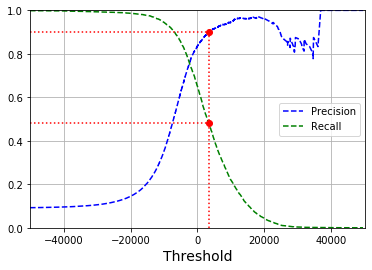

In [27]:
# 임계값에 따른 정밀도와 재현율 시각화
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.legend(loc="center right")
    plt.xlabel("Threshold", fontsize=14)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]    # np.argmax(): 최대값의 첫 번째 인덱스 반환(조건이 있다면 조건을 만족하는 첫 번째 인덱스 반환)
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # np.argmax(predicions >= 0.90): 정밀도가 0.90 이상인 첫 번째 임계값의 인덱스 반환

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

> 알 수 있는 정보
> - 임계값이 오를 때마다 정밀도는 상승하지만, 재현율은 낮아진다.
> - 재현율은 임계값이 올라감에 따라 줄어들 수 밖에 없기 때문에 부드러운 곡선이다.
> - 정밀도는 일반적으로 임계값이 오를 때 높아지지만, 가끔 낮아질 때가 있기 때문에 그래프 모양을 보면 재현율 곡선에 비해 울퉁불퉁하다.

> 적절한 정밀도/재현율을 선택하기 위한 방법으로 아래와 같이 재현율에 대한 정밀도 곡선을 그리면 좋다.

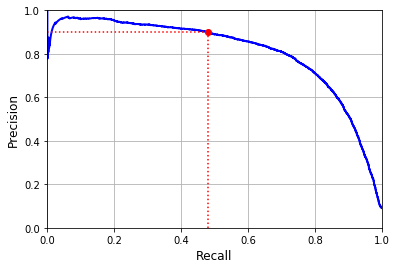

In [28]:
# 재현율에 대한 정밀도 시각화
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

> 재현율 80% 근처에서 정밀도가 급격하게 줄어드는 것을 확인할 수 있다.
> - 이처럼 급격하게 하강하는 지점의 직전을 정밀도/재현율의 trade off로 선택하는 것이 좋다.
> - 이러한 선택은 물론 프로젝트에 따라 달라진다.
>   - 만일 정밀도 90%를 달성하는 것이 목표일 경우 아래와 같이 임계값을 찾을 수 있을 것이다.

In [29]:
# 정밀도 90% 달성을 위한 임계값 확인
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [30]:
# 훈련 세트에 대한 예측 생성(임의의 threshold 사용했기 때문에 predict() 대신 다음의 코드 사용)
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [31]:
# 예측에 대한 정밀도와 재현율 확인
print('Precision:', precision_score(y_train_5, y_train_pred_90))
print('Recall:', recall_score(y_train_5, y_train_pred_90))

Precision: 0.9000345901072293
Recall: 0.4799852425751706


> 정밀도 90%의 분류기 생성 완료!

## 3.5. ROC 곡선

> ROC 곡선은 `roc_curve()` 함수를 통해 여러 임계값에서의 TPR 및 FPR을 계산하여 그릴 수 있다.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

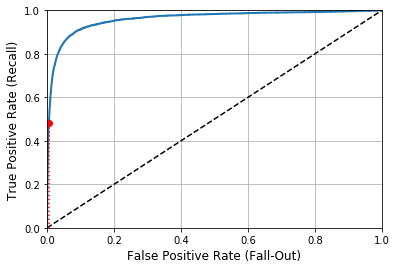

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')    # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)    # Not shown
    plt.grid(True)                                            # Not shown

plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

> - TPR과 FPR 또한 trade-off 관게에 있으며, TPR이 높을수록 FPR이 늘어난다.
> - 검은 점선의 경우 완전한 랜덤 분류기의 ROC 곡선을 의미한다.
> - 좋은 분류기는 점선에서 최대한 멀리(왼쪽 위 모서리로) 떨어져 있어야 한다.

> 분류기들을 비교하기 위해서는 AUC(area under the curve)를 측정한다.
> - 좋은 분류기의 AUC는 1이며, 완전한 랜덤 분류기는 0.5이다.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> `RandomForestClassifier` 모델을 훈련시켜 SGDClassifier의 ROC 곡선및 AUC를 비교해보자.
> - 단, RandomForestClassifier에는 decision_function() 메서드가 없으며 대신 `predict_proba()` 메서드가 있다.
>   - predict_proba()는 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [36]:
y_scores_forest = y_probas_forest[:, 1]    # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

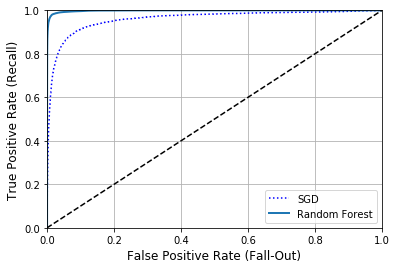

In [37]:
plt.plot(fpr, tpr, 'b:', label='SGD')    # SGD의 ROC 곡선
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')    # Random Forest의 ROC 곡선
plt.legend(loc='lower right')
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)   # Random Forest의 AUC score

0.9983436731328145

> RandomForest가 SGDClassifier에 비해 훨씬 성능이 좋아 보임을 확인할 수 있다!

# 4. 다중 분류

> 다중 분류기가 동작하는 방법은 크게 OvR과 OvO로 나뉜다.
> - 일반적으로는 OvR 방법이 선호되지만, SVM과 같이 훈련 세트의 크기에 민감한 일부 알고리즘의 경우 OvO가 선호된다.

In [39]:
# SVC 모델 학습 및 예측
from sklearn.svm import SVC
# svm_clf = SVC()
# svm_clf.fit(X_train, y_train)  # y_train_5가 아닌 y_train 사용

# 모델의 학습 시간이 너무 오래 걸림에 따라 모델을 따로 저장 후 불러와서 사용
# joblib.dump(svm_clf, "svm_clf.pkl")  # 모델 저장

svm_clf = joblib.load("svm_clf.pkl")  # 모델 불러오기
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
# 각 Class별 결정 점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

> 가장 높은 점수(9.313...)를 가진 Class는 5에 해당하는 값이다.

In [41]:
np.argmax(some_digit_scores)    # 가장 높은 점수의 Class 확인

5

> 분류기가 훈련될 때 `classes_` 속성에 타깃 Class의 리스트를 값으로 정렬하여 저장한다.
> - 단, 이번 예제에서는 각 Class의 index가 Class 값 자체와 같다는 점에 유의하자.

In [42]:
svm_clf.classes_    # 모델의 Class 확인

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

> 사이킷런에서는 모델에 따라 OvO나 OvR을 자동으로 적절하게 실행하지만, `OneVsOneClassifier`나 `OneVsRestClassifier`을 사용하여 사용을 강제할 수도 있다.

In [44]:
# OvR(One-versus-the-Rest) 전략을 사용한 SVM의 다중 클래스 분류
from sklearn.multiclass import OneVsRestClassifier
# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)

# 모델 학습 시간이 너무 오래 걸려서 모델을 따로 저장 후 불러와서 사용
# joblib.dump(ovr_clf, "ovr_clf.pkl")   # 모델 저장
ovr_clf = joblib.load("ovr_clf.pkl")  # 모델 불러오기

ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
len(ovr_clf.estimators_)    # 모델의 추정기 개수 확인

10

> 해당 예제(SVM)에서 OvR을 사용할 경우 모델의 학습 시간이 굉장히 많이 늘어남을 확인할 수 있다.
> - OvO는 10분 정도 걸렸으나, OvR은 대략 50분 정도가 걸렸다...

In [46]:
# SGDClassifier 모델을 사용한 다중 클래스 분류
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [47]:
sgd_clf.decision_function([some_digit])   # 각 Class별 결정 점수 확인

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")    # 교차 검증

array([0.87365, 0.85835, 0.8689 ])

> 모든 test fold에서 85% 이상의 정화도를 얻었다.
> - 랜덤 분류기를 사용했다면 10%의 정확도를 얻었을 것이다.

> 나쁜 점수는 아니지만, 성능을 더 높일 여지가 있으므로 Sclaing을 통해 정확도를 높여보자.

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

> 정확도를 89% 이상으로 높일 수 있었다!

# 5. 에러 분석

> 이후 단계부터는 앞선 단계까지 데이터에 대하여 여러 모델을 테스트하고, 몇 가지 좋은 모델을 선택한 뒤, 하이퍼파라미터를 튜닝하여 `가능성 높은 모델을 하나 찾았다`는 가정하에 이 모델의 성능을 향상시킬 방법을 찾아보자.

> 모델의 성능을 향상시키는 방법 중 하나는 `만들어진 에러의 종류를 분석하는 것`이다.
> - 가장 먼저 오차 행렬(confusion matrix)를 살펴볼 수 있을 것이다.

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)    # 예측 생성
conf_mx = confusion_matrix(y_train, y_train_pred)   # 오차 행렬 생성
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

> 오차 행렬의 경우 matplotlib의 matshow() 함수를 사용하여 표현하면 보기 편할 때가 많다.

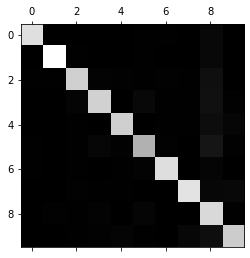

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

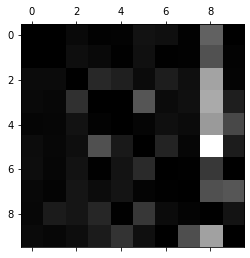

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

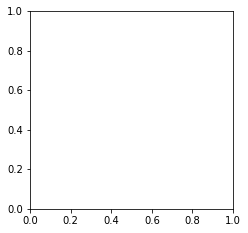

In [54]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 6. 다중 레이블 분류